In [1]:
include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

# choose config files from folder config_files

# include("../src/config_files/2dLink.jl")
# include("../src/config_files/2dFall.jl")
# include("../src/config_files/2dSwim.jl")
# include("../src/config_files/2dThrow.jl")
# include("../src/config_files/3dHinge.jl")
# include("../src/config_files/3dPrismatic.jl")
include("../src/config_files/3dCylindrical.jl")

Config info set up.


In [2]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints,config_system)
system

ndim = 3, njoint = 4, nbody = 4
ndof = 24, nudof = 8, ncdof = 16, np = 7, na = 1
udof = [3, 6, 9, 12, 15, 18, 21, 24]
udof_p = [3, 9, 12, 15, 18, 21, 24]
udof_a = [6]
nudof_HERK = 7, ncdof_HERK = 17
udof_HERK = [3, 9, 12, 15, 18, 21, 24]
gravity = [0.0, -9.8, 0.0]


In [3]:
# # test function UpdatePosition!
# bodys, joints, system = UpdatePosition!(bodys, joints, system)

# # test function UpdateVelocity!
# for i = 1:nbody
#     @assert length(bodys[i].v) == 6
#     @assert length(bodys[i].Xp_to_b) == 36
#     @assert length(joints[i].vJ) == 6
# end
# v = ones(Float64,24)
# bodys, joints, system, vJ = UpdateVelocity!(bodys, joints, system, v)

In [4]:
# init system
bodys, joints, system, soln = InitSystem!(bodys, joints, system, scheme)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bodys))

1-element Array{Any,1}:
 [0.0 0.0 0.25 0.25; 0.25 0.25 0.5 0.5; 0.5 0.5 0.75 0.75; 0.75 0.75 1.0 1.0]

[0.0 -0.707107 -0.707107 0.0; 0.0 -0.707107 -0.707107 0.0; 0.0 -0.707107 -0.707107 0.0; 0.0 -0.707107 -0.707107 0.0]

[0.0 0.707107 0.707107 0.0; 0.0 0.707107 0.707107 0.0; 0.0 0.707107 0.707107 0.0; 0.0 0.707107 0.707107 0.0]

In [5]:
# advance in time
idx = 0
@time begin
while soln.t < tf
    # advance one step
    soln, bodys, joints, system = HERK!(soln, bodys, joints, system, scheme, tol)
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bodys))
        
    # print progress
    idx += 1
    if mod(idx,500) == 1 
        @printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
#         println("center of mass at", MassCenter(bodys, system))
    end
end
@printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
end

itr = 1, t = 0.001, dt = 4.616621e-05
itr = 501, t = 0.054, dt = 1.213976e-04
itr = 1001, t = 0.115, dt = 1.213976e-04
itr = 1501, t = 0.176, dt = 1.213974e-04
itr = 2001, t = 0.236, dt = 1.213966e-04
itr = 2501, t = 0.297, dt = 1.213949e-04
itr = 3001, t = 0.358, dt = 1.213923e-04
itr = 3501, t = 0.418, dt = 1.213891e-04
itr = 4001, t = 0.479, dt = 1.213860e-04
itr = 4501, t = 0.540, dt = 1.213837e-04
itr = 5001, t = 0.601, dt = 1.213830e-04
itr = 5501, t = 0.661, dt = 1.213841e-04
itr = 6001, t = 0.722, dt = 1.213865e-04
itr = 6501, t = 0.783, dt = 1.213895e-04
itr = 7001, t = 0.843, dt = 1.213924e-04
itr = 7501, t = 0.904, dt = 1.213946e-04
itr = 8001, t = 0.965, dt = 1.213961e-04
itr = 8501, t = 1.025, dt = 1.213970e-04
itr = 9001, t = 1.086, dt = 1.213975e-04
itr = 9501, t = 1.147, dt = 1.213979e-04
itr = 10001, t = 1.208, dt = 1.213985e-04
itr = 10501, t = 1.268, dt = 1.213997e-04
itr = 11001, t = 1.329, dt = 1.214016e-04
itr = 11501, t = 1.390, dt = 1.214045e-04
itr = 12001, t =

In [6]:
using MAT
using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = linspace(0,solns[end].t,length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))[t_reg]
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

# write to .mat file for animation
# vs_reg follow the form [ntime][nbody, nverts, xyz]
matwrite("../matlab_plot/verts_i.mat", Dict(
    "ndim" => system.ndim,
    "nbody" => system.nbody,
    "nverts" => bodys[1].nverts,
    "t" => collect(t_reg),
    "verts" => vs_reg
))

Interact.Options{:SelectionSlider,Any}(9: "input-3" = 165 Any , "i", 165, "165", 165, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(288, "288"),Pair{Any,Any}(306, "306"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(134, "134"),Pair{Any,Any}(158, "158"),Pair{Any,Any}(160, "160"),Pair{Any,Any}(215, "215"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(131, "131"),Pair{Any,Any}(249, "249")…)), Any[], Any[], true, "horizontal")

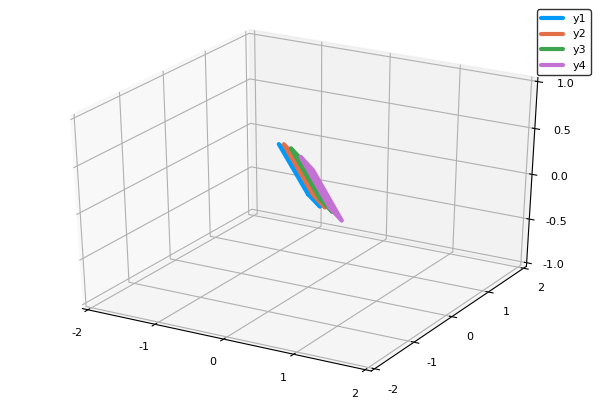

In [10]:
using Reactive, Interact
using Plots
pyplot()

# set intervals of plotting
freq = 100

@manipulate for i in 1:Int(round(length(t_reg)/freq)-1)

    if system.ndim == 2
        k = i*freq+1
        # first body
        plot(vs_reg[k][1,2:3,1],vs_reg[k][1,2:3,2], linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,2:3,1],vs_reg[k][j,2:3,2], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-1,1))
    else
        k = i*freq+1
        h = [1:bodys[1].nverts;1]
        plot(vs_reg[k][1,h,1],vs_reg[k][1,h,2],vs_reg[k][1,h,3]
             , linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,h,1],vs_reg[k][j,h,2],vs_reg[k][j,h,3]
              , linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-1,1))        
    end

end

In [8]:
# # results printed
# solns[end].qJ
# solns[end].v
# solns[end].v̇
# solns[end].λ
# solns[end].t

# # code analysis
# using BenchmarkTools, Compat
# @benchmark HERK!(soln, bodys, joints, system, scheme, tol)
# @profile HERK!(soln, bodys, joints, system, scheme, tol)
# Profile.print()

# using Coverage
# m = analyze_malloc("../src")
# m[end-20:end]